In [1]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict



sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

tqdm.pandas()

In [2]:
import yfinance as yf
from datetime import date

end_date = date.today().strftime("%Y-%m-%d")
start_date = '2008-01-01'

df = yf.download('AAPL', start=start_date, end=end_date)

# Inspect the data
print(df.head())
print(df.info())

[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close      Volume
Date                                                                     
2008-01-02  7.116786  7.152143  6.876786  6.958571   5.869882  1079178800
2008-01-03  6.978929  7.049643  6.881786  6.961786   5.872595   842066400
2008-01-04  6.837500  6.892857  6.388929  6.430357   5.424310  1455832000
2008-01-07  6.473214  6.557143  6.079643  6.344286   5.351703  2072193200
2008-01-08  6.433571  6.516429  6.100000  6.116071   5.159194  1523816000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4270 entries, 2008-01-02 to 2024-12-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4270 non-null   float64
 1   High       4270 non-null   float64
 2   Low        4270 non-null   float64
 3   Close      4270 non-null   float64
 4   Adj Close  4270 non-null   float64
 5   Volume     4270 non-null   int64  
dtypes: float64(5), int64(1)
memory us

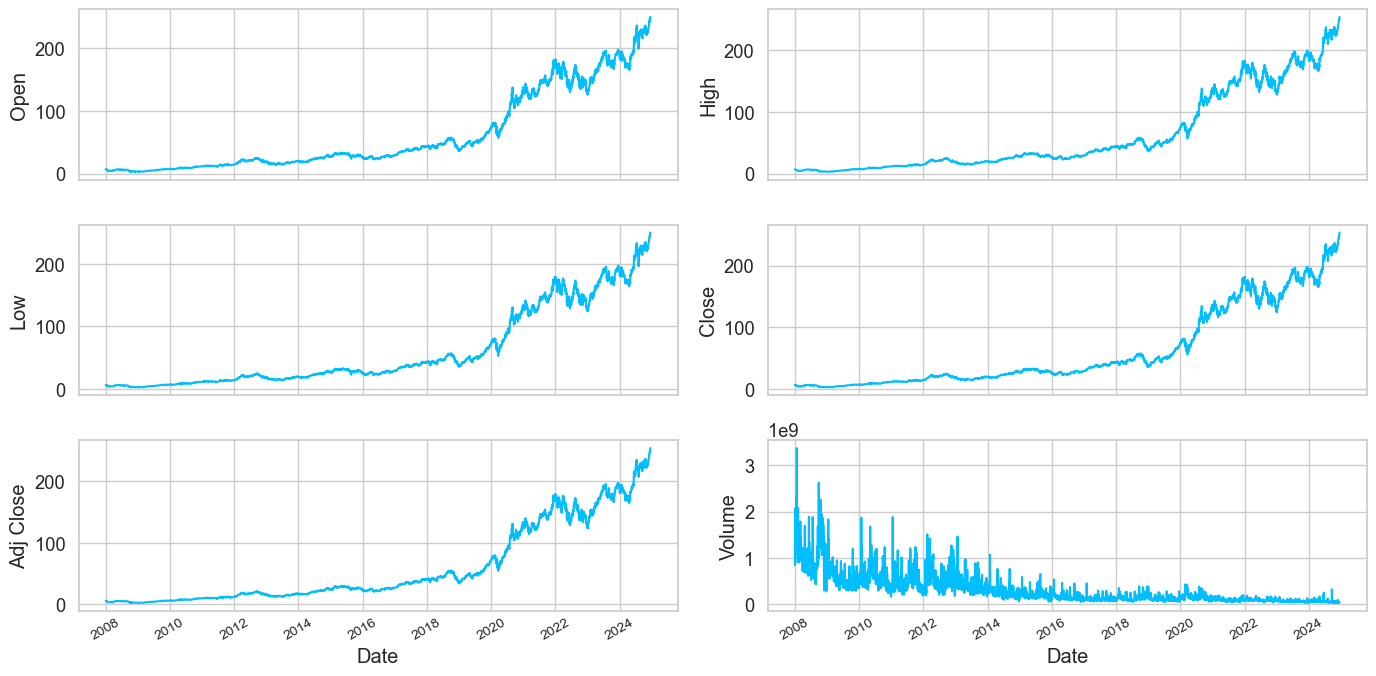

In [3]:
import matplotlib.dates as mdates

def data_plot(df):
    # Plot line charts
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

# Plot the data
data_plot(df)

In [4]:
import math
from sklearn.preprocessing import MinMaxScaler

# Train test split
training_data_len = math.ceil(len(df) * .8)
print(training_data_len)

# Splitting the dataset
train_data = df[:training_data_len].iloc[:, :1]
test_data = df[training_data_len:].iloc[:, :1]
print(train_data.shape, test_data.shape)

# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)

# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
# Scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_test[:5])

3416
(3416, 1) (854, 1)
(3416, 1)
(854, 1)
[[0.02924381]
 [0.02830219]
 [0.02733618]
 [0.02484796]
 [0.02457718]]
[[0.15152733]
 [0.15056017]
 [0.1480616 ]
 [0.1640203 ]
 [0.15958729]]


In [5]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])  # Predicting the value right after the sequence
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])  # Predicting the value right after the sequence
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([3366, 50, 1]) torch.Size([3366, 1])
torch.Size([824, 30, 1]) torch.Size([824, 1])


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

input_size = 1
num_layers = 3  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Learning rate

batch_size = 32  # Adjusted batch size
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

cpu
Epoch [10/100] - Training Loss: 0.0005, Test Loss: 0.0026
Epoch [20/100] - Training Loss: 0.0003, Test Loss: 0.0020
Epoch [30/100] - Training Loss: 0.0002, Test Loss: 0.0014
Epoch [40/100] - Training Loss: 0.0002, Test Loss: 0.0012
Epoch [50/100] - Training Loss: 0.0002, Test Loss: 0.0011
Epoch [60/100] - Training Loss: 0.0002, Test Loss: 0.0011
Epoch [70/100] - Training Loss: 0.0001, Test Loss: 0.0009
Epoch [80/100] - Training Loss: 0.0001, Test Loss: 0.0009
Epoch [90/100] - Training Loss: 0.0002, Test Loss: 0.0009
Epoch [100/100] - Training Loss: 0.0001, Test Loss: 0.0010


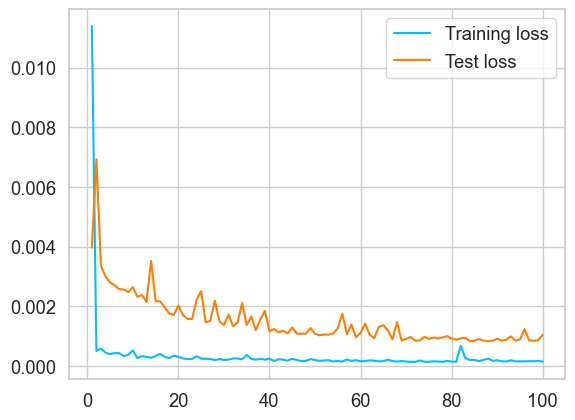

In [7]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

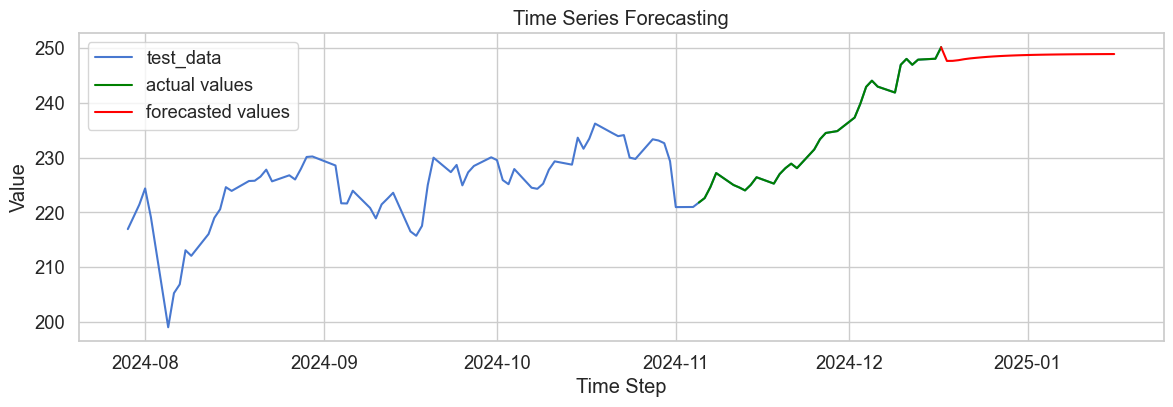

RMSE: 0.0325
R² Score: 0.9788


In [8]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:], test_data.Open[-100:], label="test_data", color="b")
plt.plot(test_data.index[-30:], test_data.Open[-30:], label='actual values', color='green')
plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data.Open[-1:], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]), label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()

# Evaluate the model and calculate RMSE and R² score
model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)  # Add batch dimension
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')